# Solving the Travelling Salesman Problem with MiniSom

This is a modified version of example available at: https://glowingpython.blogspot.com/2020/06/solving-travelling-salesman-problem.html 

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
from haversine import haversine
import networkx as nx
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# Define latitude and longitude for twenty major U.S. cities
cities = {
    'New York City': (40.72, -74.00),
    'Philadelphia': (39.95, -75.17),       
    'Baltimore': (39.28, -76.62),
    'Charlotte': (35.23, -80.85),
    'Memphis': (35.12, -89.97),
    'Jacksonville': (30.32, -81.70),
    'Houston': (29.77, -95.38),
    'Austin': (30.27, -97.77),
    'San Antonio': (29.53, -98.47),
    'Fort Worth': (32.75, -97.33),
    'Dallas': (32.78, -96.80),
    'San Diego': (32.78, -117.15),
    'Los Angeles': (34.05, -118.25),
    'San Jose': (37.30, -121.87),
    'San Francisco': (37.78, -122.42),    
    'Indianapolis': (39.78, -86.15),
    'Phoenix': (33.45, -112.07),       
    'Columbus': (39.98, -82.98), 
    'Chicago': (41.88, -87.63),
    'Detroit': (42.33, -83.05)
}

# Create a haversine distance matrix based on latitude-longitude coordinates
distance_matrix = defaultdict(dict)
for ka, va in cities.items():
    for kb, vb in cities.items():
        distance_matrix[ka][kb] = 0.0 if kb == ka else haversine((va[0], va[1]), (vb[0], vb[1])) 

# Convert distance diccionary into a dataframe        
distances = pd.DataFrame(distance_matrix)

city_names=list(distances.columns)    
distances=distances.values  
city_count = len(city_names)

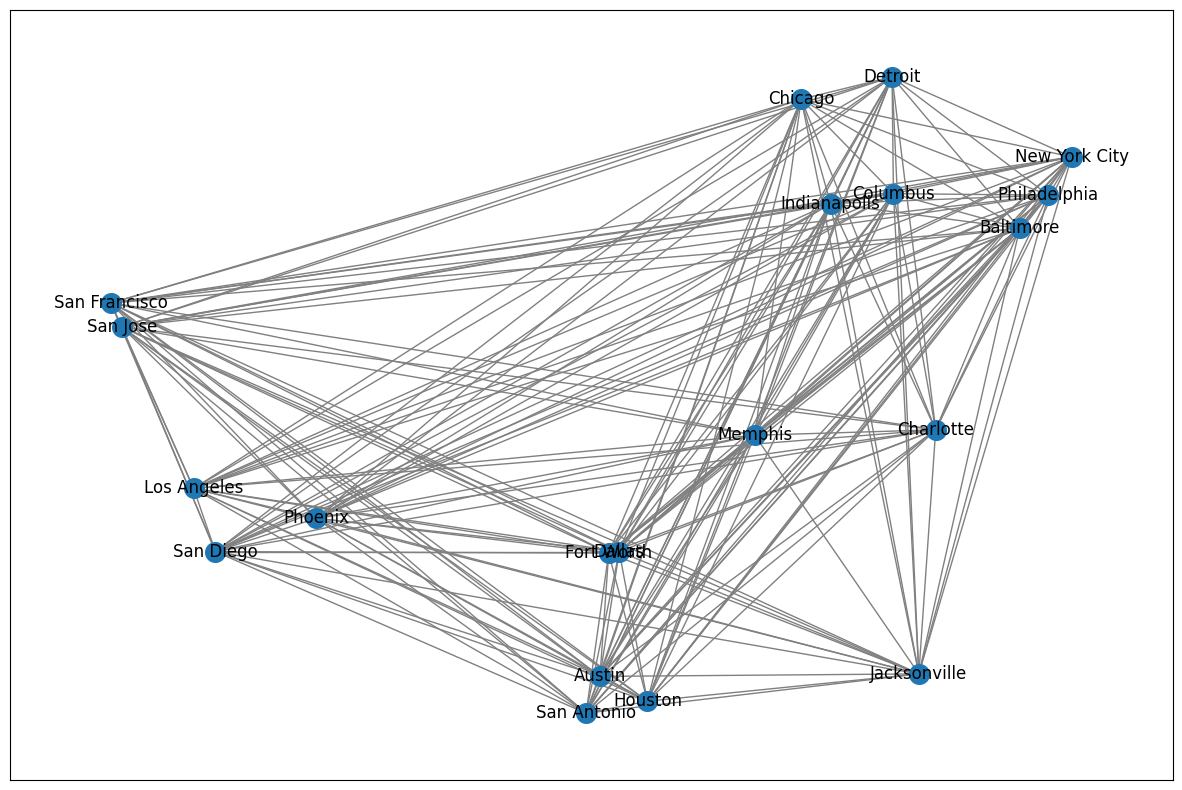

In [3]:
# Create a graph
G=nx.Graph()

for ka, va in cities.items():
    for kb, vb in cities.items():
        G.add_weighted_edges_from({(ka,kb, distance_matrix[ka][kb])})
        G.remove_edges_from(nx.selfloop_edges(G))
        
fig, ax = plt.subplots(figsize=(15,10))

# Reverse lat and long for correct visualization
reversed_dict = {key: value[::-1] for key, value in cities.items()}

# Create an independent shallow copy of the graph and attributes
H = G.copy()
 
# Draw the network
ax=nx.draw_networkx(
    H,
    pos=reversed_dict,
    with_labels=True,
    edge_color="gray",
    node_size=200,
    width=1,
)

plt.show()

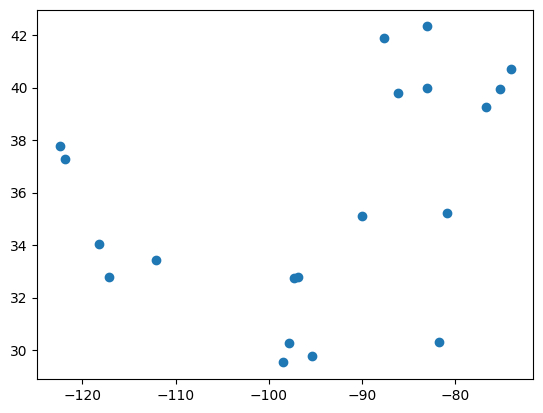

In [4]:
# Get the x (longitude) and y (latitude) 2D coordinates for each city
x = [city[1][1] for city in cities.items()]
y = [city[1][0] for city in cities.items()]
points = np.array([x,y]).T
plt.scatter(x, y)

### Solve the TSP using SOM implemented in MiniSom

In [5]:
# !pip install MiniSom

In [6]:
from minisom import MiniSom

N_neurons = city_count*2

# Create a self-organizing map with 1xN_neurons grid
som = MiniSom(1, N_neurons, 2, sigma=10, learning_rate=.5,
              neighborhood_function='gaussian', random_seed=50)
# Initialize weights
som.random_weights_init(points)

### Visualize the iterations

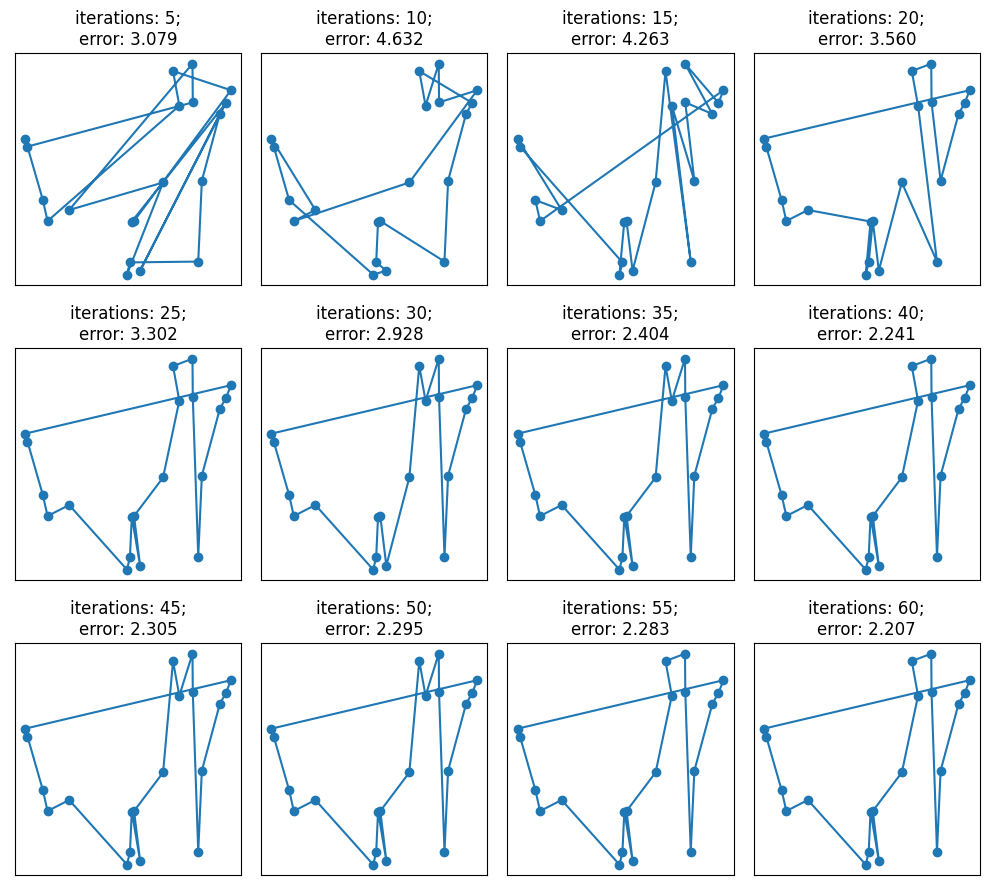

In [7]:
plt.figure(figsize=(10, 9))
for i, iterations in enumerate(range(5, 61, 5)):
    som.train(points, iterations, verbose=False, random_order=False)
    plt.subplot(3, 4, i+1)
    plt.scatter(x,y)
    visit_order = np.argsort([som.winner(p)[1] for p in points])
    visit_order = np.concatenate((visit_order, [visit_order[0]]))
    plt.plot(points[visit_order][:,0], points[visit_order][:,1])
    plt.title("iterations: {i};\nerror: {e:.3f}".format(i=iterations, 
                                                        e=som.quantization_error(points)))
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

### Run more iterations and visualize the progress

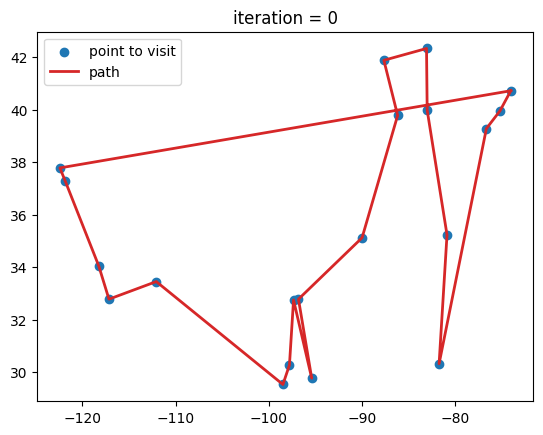

In [8]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

max_iter = 2000

paths_x = []
paths_y = []
for i in np.arange(max_iter):
    i_point = i % len(points)
    som.update(points[i_point], som.winner(points[i_point]), i, max_iter)
    visit_order = np.argsort([som.winner(p)[1] for p in points])
    visit_order = np.concatenate((visit_order, [visit_order[0]]))
    paths_x.append(points[visit_order][:,0])
    paths_y.append(points[visit_order][:,1])

fig, ax = plt.subplots()
plt.scatter(x, y, label='point to visit')
ln, = plt.plot([], [], 'C3', linewidth=2, label='path')
plt.legend()

def update(frame):
    ln.set_data(paths_x[frame], paths_y[frame])
    plt.title('iteration = %d' % frame)
    return ln,

ani = FuncAnimation(fig, update, frames=np.arange(max_iter),
                    interval=10, repeat=False, blit=False)
HTML(ani.to_html5_video())